In [1]:
from datetime import time

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')

In [2]:

from tools.optimization import create_multi_objective_optimizer, filter_inf_results, plot_simple_multi_event_convergence
from tools.optimization import run_multi_event_optimization, plot_single_event_comparison, plot_multi_event_convergence, plot_single_event_convergence

In [3]:
from tools.geometry import generate_detector
import jax.numpy as jnp
default_json_filename='../config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)

In [9]:
results = run_multi_event_optimization(
   # detector_points,
    N_events=10,
    Nphot=500_000,
    K=2,
    loss_function='multi_objective',
    energy_lr=2.0,     
    spatial_lr=0.1,
    position_scale=2.0,
    lambda_time=0.0,
    n_iterations=2000,
    patience=250,
    base_seed=100,
    verbose=False
)

import pickle

# Save to file
with open('optimization_results_seeds_new_ref_50kC.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing events: 100%|██████████| 10/10 [11:54<00:00, 71.46s/it]


In [14]:
with open('optimization_results_seeds_new_ref_50kC.pkl', 'rb') as f:
    loaded_results = pickle.load(f)
new_results = filter_inf_results(loaded_results)

Filtered out 0 events with inf values.
Infinity breakdown: 0 energy-only, 0 spatial-only, 0 both components
Remaining events: 10


In [15]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 8


=== Final Iteration Statistics (N=10 events) ===
Energy Error - Mean: 3.4665, Std: 5.6800
Position Distance - Mean: 0.0603, Std: 0.0233
Angle Opening - Mean: 0.0154 rad (0.88°), Std: 0.0051 rad
Plot saved to: multi_evt_opt_summary_tmp.pdf


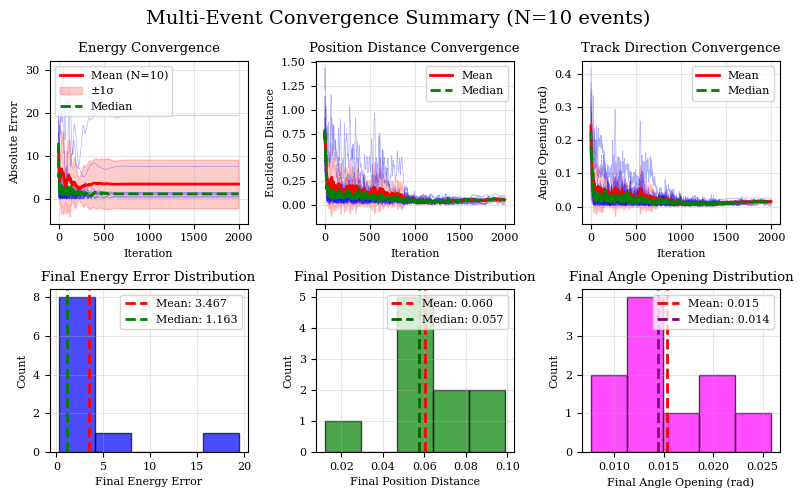

In [16]:
_ = plot_simple_multi_event_convergence(new_results, show_individual=True, show_statistics=True, show_histograms=True, figsize=(8,5), save_path='multi_evt_opt_summary_tmp.pdf')

In [17]:
import numpy as np
np.argmin(new_results['loss_histories'][3]['spatial'])

Array(1136, dtype=int32)

In [18]:
new_results['loss_histories'][0]['energy'][444],  new_results['loss_histories'][0]['energy'][1897]

(Array(0.00079028, dtype=float32), Array(0.00105962, dtype=float32))

In [ ]:
new_results['param_histories'][28].keys(), new_results['true_params'][28]

In [ ]:
def get_error_at_iteration(results, ID, iteration):

    def get_opening_angle(true_theta, true_phi, recon_theta, recon_phi):
        true_dir = np.array([
            np.sin(true_theta) * np.cos(true_phi),
            np.sin(true_theta) * np.sin(true_phi),
            np.cos(true_theta)
        ])
        recon_dir = np.array([
            np.sin(recon_theta) * np.cos(recon_phi),
            np.sin(recon_theta) * np.sin(recon_phi),
            np.cos(recon_theta)
        ])

        cos_angle = np.clip(np.dot(true_dir, recon_dir), -1.0, 1.0)
        angle_opening = np.arccos(cos_angle)

        return angle_opening

    best_spatial_it = np.argmin(results['loss_histories'][ID]['spatial'])

    final_E_err = results['final_errors'][ID]['energy']
    final_dist_err = results['final_errors'][ID]['position']
    final_phi_err = results['final_errors'][ID]['theta']
    final_theta_err = results['final_errors'][ID]['phi']

    E_reco_final = results['param_histories'][ID]['energy'][iteration]
    E_true = results['true_params'][ID][0]
    E_err_final = abs(E_reco_final-E_true)

    P_reco =  np.array([results['param_histories'][ID]['position_x'][iteration], results['param_histories'][ID]['position_y'][iteration], results['param_histories'][ID]['position_z'][iteration]])
    P_true = results['true_params'][ID][1]
    P_err_final = np.linalg.norm(P_reco - np.array(P_true))

    theta_true = results['true_params'][ID][2][0]
    phi_true = results['true_params'][ID][2][1]

    theta_reco = results['param_histories'][ID]['theta'][iteration]
    phi_reco = results['param_histories'][ID]['phi'][iteration]

    A_err_final = get_opening_angle(theta_true, phi_true, theta_reco, phi_reco)

    return E_err_final, P_err_final, A_err_final

In [ ]:
new_results['true_params'][28]

In [ ]:
ID =0

last_it = get_error_at_iteration(new_results, ID, -1)
print(*last_it)

best_spatial_iteration = np.argmin(new_results['loss_histories'][ID]['spatial'])

best_sp = get_error_at_iteration(new_results, ID, best_spatial_iteration)
print(*best_sp)

best_energy_iteration = np.argmin(new_results['loss_histories'][ID]['energy'])

best_en = get_error_at_iteration(new_results, ID, best_energy_iteration)
print(*best_en)


In [ ]:
# plot_multi_event_convergence(
#     new_results, 
#     save_path=None,
#     show_individual=False,
#     show_statistics=True
# )

In [ ]:
from tools.optimization import plot_simple_event_convergence

for i in range(20):
    plot_simple_event_convergence(i, new_results, save_path=None, figsize=(7, 2))

In [ ]:
# plot_single_event_convergence(0, new_results, save_path=None, figsize=(8, 8))